In [1]:
#from models.vae_hist_glm2 import VAE_Hist_GLM2, NN_Encoder
#from models.vae_hist_glm import VAE_Hist_GLM, NN_Encoder
#from models.vae_hist_glm3 import VAE_Hist_GLM3, NN_Encoder
#from models.vae_hist_glm4 import VAE_Hist_GLM4, NN_Encoder
#from models.vae_hist_glm5 import VAE_Hist_GLM5, NN_Encoder, NN_Decoder
from models.vae_hist_glm6 import NN_Encoder, NN_Decoder

import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 6000
epoch_no = 15
layer_no = 3

In [4]:
V_train = V[:T_train].to(device).float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = NN_Decoder(C_den, C_syn_e, C_syn_i, T_no, device)
#decoder = VAE_Hist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.0001)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="none")
mse_criterion = nn.MSELoss()

6076
382


In [6]:
Z_prior = torch.ones(batch_size).to(device) * 0.001
loss_factor = 1
temp_list = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
temp_count = 0

true = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")[:,:50000].flatten()[T_train:T_train+T_test]
old = np.load("/media/hdd01/sklee/CA1_clust4-60/alpha_sub6_output.npz")["test"]

old_score = metrics.explained_variance_score(y_true=true, y_pred=old)

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    #if (i%500==0) & (temp_count < 14):
        #temp = temp_list[temp_count]
        #temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    spk_enc, Z_enc = encoder(batch_V, batch_E_neural, batch_I_neural)
    
    V_pred, Z_pred, out_filters = decoder.train_forward(batch_E_neural, batch_I_neural, spk_enc)
    
    #V_pred, Z_pred, out_filters = decoder.train_forward(batch_E_neural,
                                                         #batch_I_neural,
                                                         #spk_enc)
    
    prior_loss = torch.mean(bce_criterion(Z_enc , Z_prior))
    bern_loss = torch.mean( bce_criterion(Z_pred, Z_enc.detach()))
    var_loss = torch.var(batch_V - V_pred)    
    
    loss_var_exp = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      y_pred=V_pred.cpu().detach().numpy())
    
    #smooth_loss = torch.mean((out_filters[:,1:] - out_filters[:,:-1]) ** 2)    
    
    loss = var_loss + bern_loss + prior_loss
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    if i%500 == 499:
        test_V_pred, test_Z_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
        test_spk_enc, test_Z_enc = encoder(V_test, test_E_neural, test_I_neural)
        
        new = old + test_V_pred.cpu().detach().numpy()
        
        new_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=new)

        
        print(i, new_score, old_score, loss_var_exp)
        print(bern_loss.item(), prior_loss.item())

<ipython-input-6-3baf8237d5cc>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


499 0.9101808743514073 0.9141887469103781 -0.03559684753417969
0.008122516795992851 0.008117555640637875
999 0.9125276204728008 0.9141887469103781 -0.02222895622253418
0.005973289720714092 0.008256245404481888
1499 0.9081343192787085 0.9141887469103781 0.3047093152999878
0.01727071963250637 0.009417744353413582
1999 0.9099765802989614 0.9141887469103781 0.41141587495803833
0.020637191832065582 0.010717688128352165
2499 0.9115153468639677 0.9141887469103781 0.3734312653541565
0.01369924284517765 0.009824130684137344
2999 0.9088659316610743 0.9141887469103781 0.42981475591659546
0.013518638908863068 0.010011712089180946
3499 0.9102663521545686 0.9141887469103781 0.5319229960441589
0.01618799939751625 0.010398440062999725
3999 0.9112097563004785 0.9141887469103781 0.5930593609809875
0.016794908791780472 0.010834596119821072
4499 0.9116207568398942 0.9141887469103781 0.5999258756637573
0.014509604312479496 0.010483233258128166
4999 0.9129969788723158 0.9141887469103781 0.654551088809967
0.

In [56]:
test_V_pred, test_Z_pred, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
test_spk_enc, test_Z_enc = encoder(V_test, test_E_neural, test_I_neural)
        
new = old + test_V_pred.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(true[17000:25000], c="black", alpha=0.7, linewidth=1)
plt.plot(new[17000:25000], c="red", alpha=0.7, linewidth=1)
plt.plot(old[17000:25000], c="blue", alpha=0.7, linewidth=1)

new_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=new)
old_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=old)

print(old_score, new_score)

0.9141887469103781 0.9129107211977974


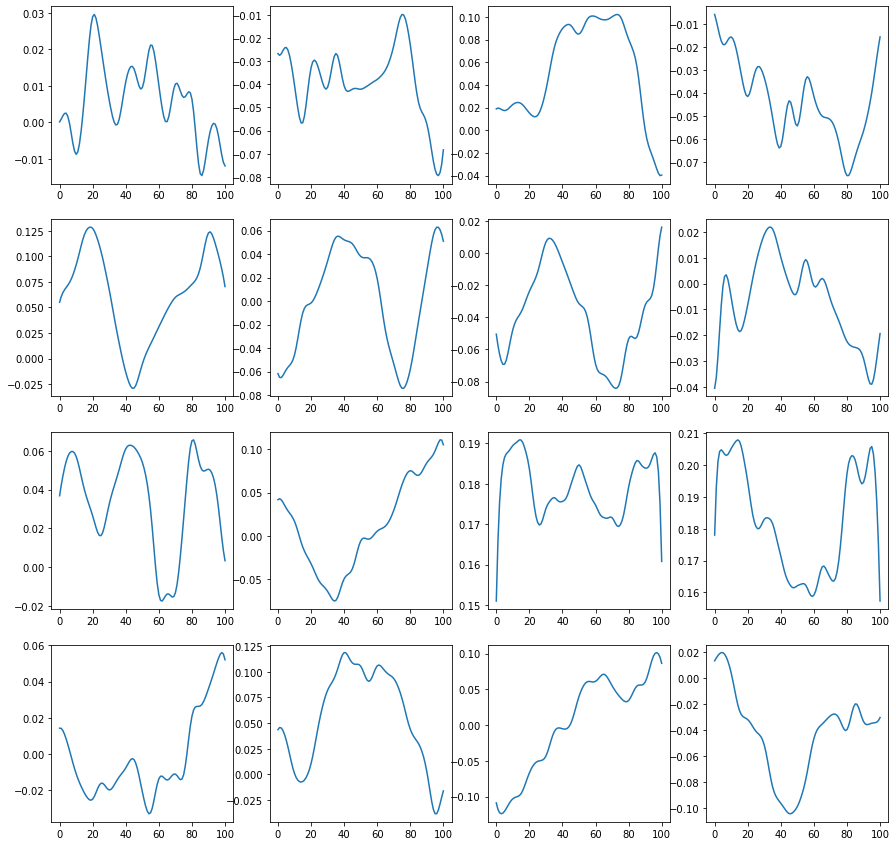

In [10]:
fig, axs = plt.subplots(nrows=4,ncols=4, figsize=(15,15))
for row in range(4):
    for col in range(4):
        axs[row,col].plot(test_out_filters[row*4+col].cpu().detach().numpy())

In [32]:
print(np.max(true))
print(np.min(true))

-59.832764106857546
-68.57424286283448


In [53]:
max_val = -59.75
min_val = -68.5

bin_edges = np.arange(min_val, max_val+0.01,0.25)
means = np.zeros((bin_edges.shape[0]-1, 3))
var = np.zeros((bin_edges.shape[0]-1, 3))
for i in range(means.shape[0]):    
    means[i,1] = np.mean(old[(true >= min_val+0.25*i) & (true < min_val+0.25*i+0.25)])
    means[i,2] = np.mean(new[(true >= min_val+0.25*i) & (true < min_val+0.25*i+0.25)])
    means[i,0] = min_val + 0.25*i + 0.125
    var[i,1] = np.var(old[(true >= min_val+0.25*i) & (true < min_val+0.25*i+0.25)])
    var[i,2] = np.var(new[(true >= min_val+0.25*i) & (true < min_val+0.25*i+0.25)])

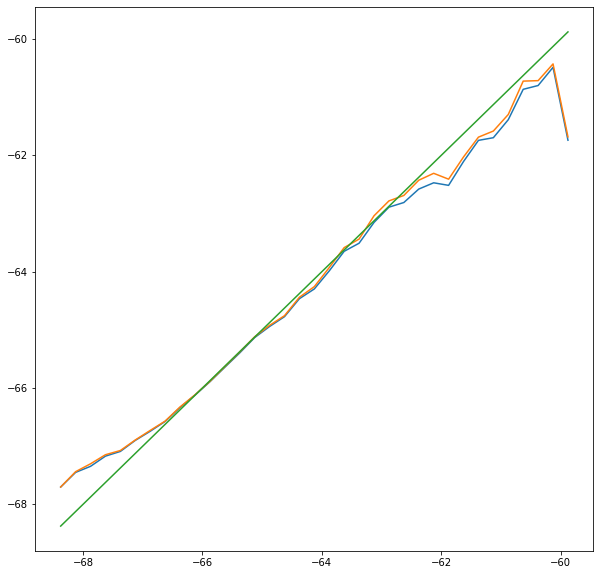

In [55]:
plt.figure(figsize = (10,10))
plt.plot(means[:,0],means[:,1])
plt.plot(means[:,0],means[:,2])
plt.plot(means[:,0], means[:,0])


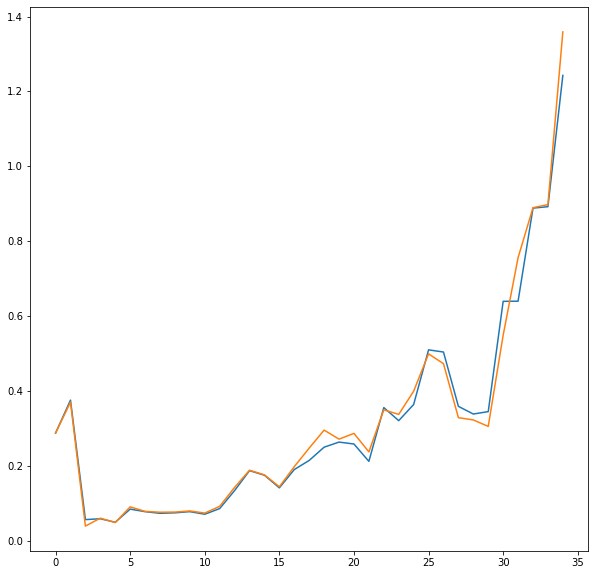

In [50]:
plt.figure(figsize = (10,10))
plt.plot(var[:,0])
plt.plot(var[:,1])